# Generative Models

### How to run this notebook

Easy way:

* Go to colab.reasearch.google.com and log in with your google account
* Upload this File
* Go to Edit/Bearbeiten > Notebook settings/Notebook Einstellungen, select GPU as Hardware accelerator
* Run the notebook

Harder way:
* Install python 3
* python3 -m venv my_venv
* Activate venv 

>On unix `$ source my_ven/bin/activate`

>On windows `$ my_venv\Scripts\activate`

* Upgrade pip
`pip install --upgrade pip`

* Install tensorflow
`pip install tensorflow`

* Install other needed stuff
`pip install jupyter scipy matplotlib pydot`

* run this notebook with `jupyter notebook`


# 1. Kullback-Leibler Divergence

Kullback-Leibler Divergence is a measure of how one probability distribution is different from a second, reference probability distribution. It is defined as the expectation of the logarithmic difference between the probabilities P and  Q, where the expectation is taken using the probabilities P:
$$D_{KL}[P||Q]  = \mathbb{E}_{x \sim P}\left[\log P(x) - \log Q(x)\right] $$
For discrete probability distributions P and Q defined on the same probability space, KL-divergence is defined as a sum:
$$D_{KL}[P||Q]  = \sum_{i} P(i) log\frac{P(i)}{Q(i)}$$
For distributions P and Q of a continuous random variable, the KL-divergence as an integral:
$$D_{KL}[P||Q]  =  \int_{} P(x) log\frac{P(x)}{Q(x)}dx$$

Define function to compute KL-divergence

In [ ]:
import scipy.stats as stats
import math
import numpy as np
import matplotlib.pyplot as plt

def KL(p, q):
    epsilon = 0.00001
    p_eps = p+epsilon
    q_eps = q+epsilon

    return np.sum(p_eps*np.log(p_eps/q_eps))

The following example demonstrates KL-divergence for two normal distributions. We first plot the distributions and then the values under the integral.

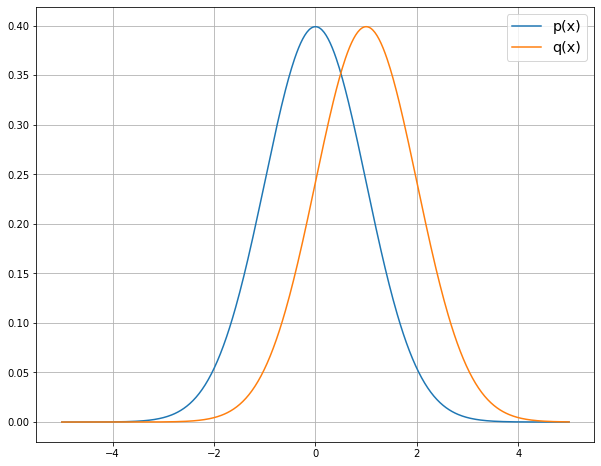

In [ ]:
x = np.linspace(-5, 5, 500)
distr_p = stats.norm.pdf(x, 0, 1)
distr_q = stats.norm.pdf(x, 1, 1)
plt.plot(x, distr_p, label="p(x)")
plt.plot(x, distr_q, label="q(x)")
plt.grid()
plt.legend(fontsize='x-large')
plt.show()

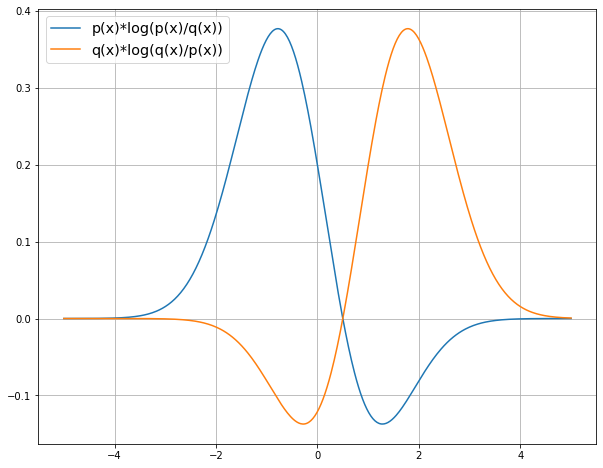

In [ ]:
plt.plot(x, distr_p*np.log(distr_p/distr_q), label="p(x)*log(p(x)/q(x))")
plt.plot(x, distr_q*np.log(distr_q/distr_p), label="q(x)*log(q(x)/p(x))")
plt.grid()
plt.legend(fontsize='x-large')
plt.show()

KL-divergence is not symmetric (and hence not a metric!). See the KL-divergence values $D_{KL}[p||q]$ and $D_{KL}[q||p]$:

In [ ]:
print("D_KL(p||q) is", KL(distr_p, distr_q))
print("D_KL(q||p) is",KL(distr_q, distr_p))

D_KL(p||q) is 24.915144261755025
D_KL(q||p) is 24.911330351815625


#### Jensen–Shannon divergence
Now we define Jensen–Shannon divergence, which also measures the similarity between two probability distributions. JS-divergence is a symmetrized and smoothed version of the KL-divergence.

In [ ]:
def JSD(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (KL(p, m) + KL(q, m))

We now plot JS-divergence for the same two distributions.

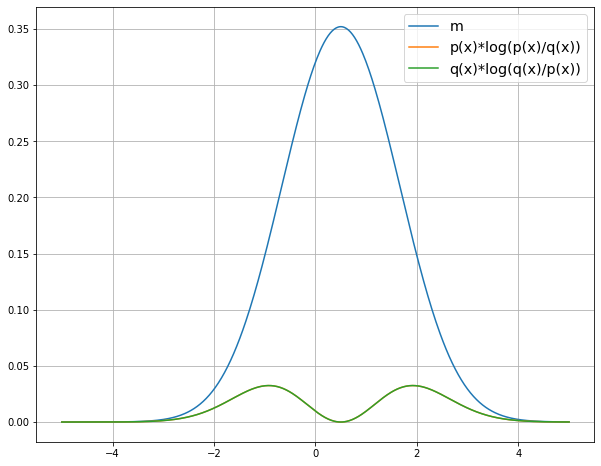

In [ ]:
m = 0.5 * (distr_p + distr_q)
plt.plot(x, m, label="m")
plt.plot(x, 0.5 * (distr_p * np.log(distr_p/m) + distr_q * np.log(distr_q/m)), label="p(x)*log(p(x)/q(x))")
plt.plot(x, 0.5 * (distr_q * np.log(distr_q/m) + distr_p * np.log(distr_p/m)), label="q(x)*log(q(x)/p(x))")
plt.grid()
plt.legend(fontsize='x-large')
plt.show()

Now we compute JS-divergence values  $D_{JS}[p||q]$ and $D_{JS}[q||p]$:

In [ ]:
print("D_JS(p||q) is", JSD(distr_p, distr_q))
print("D_JS(q||p) is", JSD(distr_q, distr_p))

D_JS(p||q) is 5.556675256812227
D_JS(q||p) is 5.556675256812227


# 2. Variation Autoencoder (VAE)

The first type of generative models is a Variational Autoencoder (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

VAEs are similar to Autoencoders. They both contain an Encoder and a Decoder. The Encoder takes an Input (Image) and "compresses" it into a latent representation. The Decoder takes the latent representation and creates from it the original input. The only difference in the architecture between VAE and Autoencoder is the latent space representation of the input.

The latent representation of the Autoencoder is a vector (a single point in the latent space), in contrast to the VAE which uses a distribution (mean and variance).
The VAE samples a vector from the Distribution and takes this vector as input for the decoder. No matter which value we sample, we still want to get the original image back --> All values from the distribution should lead to the same reconstructed image.

--> values close togehter in the latent space should lead to similar decoded images

--> continous latent space / different to autoencoder

Autoencoder uses only the reconstruction loss, VAE uses additionally the KLD as a loss.
We use the KLD to compare the predicted distribution with the standard normal distribution ($\mu$, $\sigma$) = (0,1).
No matter the input image, the VAE tries to predict (0,1), otherwise the loss increases. 

This forces the VAE to predict near (0,1) and it can't use e.g. $\sigma$=0 to circumvent sampling.

VAEs are therefore a regularized Version of a normal autoencoder which leads to better generative properties.

### Setup

In [ ]:
from __future__ import print_function, division
import time
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Lambda, LeakyReLU, Reshape, Flatten, Conv2D, MaxPooling2D, \
    Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
#from tensorflow.keras import objectives
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.data import Dataset
from scipy.stats import norm
from IPython.display import SVG

### LeakyReLU
Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope α (e.g. $α=0.01$):
$$ReLU(x) = max(0,x)$$

$$LeakyReLU(x) = max(αx,x)$$

![caption](relu.png)

LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

We will use the already implemented LeakyReLU from keras in the following neural networks

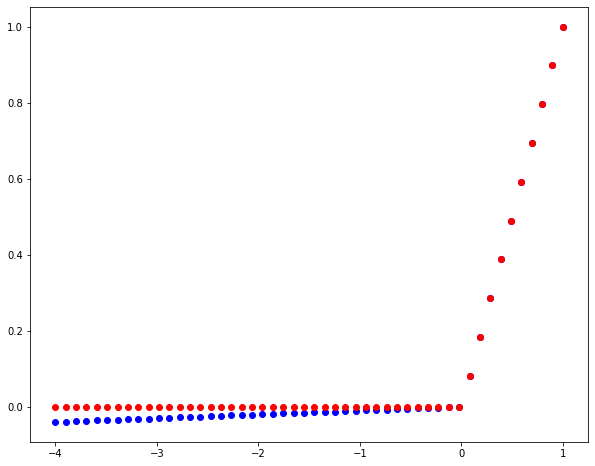

In [ ]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    
    # If x is below 0 returns alpha*x else it will return x.
    activation = tf.maximum(x,alpha*x)
    return activation

equally_spaced_array = np.linspace(-4,1,num=50)
# Leaky ReLU in blue
plt.scatter(equally_spaced_array, leaky_relu(equally_spaced_array),c="blue")
# ReLU in red
plt.scatter(equally_spaced_array, np.where(equally_spaced_array > 0,equally_spaced_array, 0 ), c="red" )
plt.show()

### VAE Setup

First define some model variables and load MNIST dataset

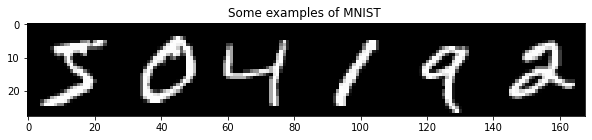

In [ ]:
# network parameters
batch_size = 100
n_epoch = 15
n_hidden = 256
# we will train a VAE with 2d latent space
latent_dim = 2

# get mnist dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# show the first six images
plt.imshow(np.concatenate((x_train[:6]), axis=1))
plt.title('Some examples of MNIST ')
plt.show()

def preprocess_images(images):
  # Reshape input to n,28,28,1 (amount of images, height, width, channels)
  # And cast them to float values between [0,1]
  return images.reshape((images.shape[0], 28, 28, 1)) / 255.

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

# create dataset that shuffles our data and creates batches
train_ds = Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
test_ds = Dataset.from_tensor_slices(
    (x_test, y_test)).batch(batch_size)

### Encoder
Define an encoder: 2 FC layers with LeakyReLUs as activation functions and two output layers: one for the mean and one for the log variance. Note that we output the log variance instead of the standard deviation because this is not only more convenient to work with, but also helps with numerical stability.

In [ ]:
encoder_inputs = Input(shape=(28,28,1),batch_size=batch_size, name='MNIST_image')
# Flatten reshapes our (n,28,28,1) tensor into a (n,784) Tensor which is fed
# to our first Fully Connected Layer
x = Flatten()(encoder_inputs)
x = Dense(n_hidden, name='hidden_enc_1')(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dense(n_hidden, name='hidden_enc_2')(x)
x = LeakyReLU(alpha=0.01)(x)

# mu and log_var both use the activated output of hidden_enc_2
mu = Dense(latent_dim, name='mu')(x)
log_var = Dense(latent_dim, name='log_var')(x)


### Reparameterization Trick

Introduce a new parameter $\epsilon \sim N(0,1)$ to allow backprop: $z=\mu + \sigma * \epsilon$.  

The outcoder outputs the log variance, but we need the standard deviation. To recover it, we simply implement the appropriate transformation and encapsulate it in a new keras layer.

Then we add this layer to the encoder

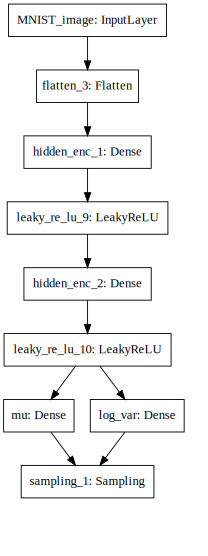

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Create a new keras layer for the reparameterization trick """
    def call(self, inputs):
        # gets mu and log_var as input
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        # creates a random value with shape [batchsize, 2]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # Reparameterization trick
        z = mu + tf.exp(0.5 * log_var) * epsilon
        return z

# connect mu and log_var to the sampling layer"
z = Sampling()([mu, log_var])

# create a keras model of the encoder
encoder = tf.keras.Model(encoder_inputs, [mu, log_var, z], name="encoder")

# visualization of the encoder with sampling
SVG(model_to_dot(encoder, show_shapes=False, dpi=65)
    .create(prog='dot', format='svg'))

### Decoder

The decoder takes the latent dimension values and tries to predict an image
We use 2 FC layers with LeakyReLU.
Then we use one FC layer with sigmoid activation for the prediction.

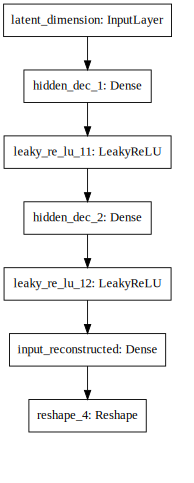

In [ ]:
latent_inputs = Input(shape=(latent_dim,), batch_size=batch_size, name='latent_dimension')
x = Dense(n_hidden//2, name='hidden_dec_1')(latent_inputs)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(n_hidden, name='hidden_dec_2')(x)
x = LeakyReLU(alpha=0.01)(x)

# predict a 28*28 pixel image, with values in (0,1)
decoder_outputs=Dense(28*28, activation='sigmoid',name='input_reconstructed')(x)
reshaped_outputs = Reshape((28,28,1))(decoder_outputs)
# create the decoder model
decoder = tf.keras.Model(latent_inputs,reshaped_outputs, name='decoder')

# visualize the decoder
SVG(model_to_dot(decoder, show_shapes=False, dpi=65)
    .create(prog='dot', format='svg'))

### Creating VAE

A new keras model is created.

We override the train_step function that is automatically called on training.
There we connect the Encoder and the Decoder, calculate the VAE-loss and update the weights. 

VAE Loss consists of the reconstruction loss (is the input image similar to the output image) and
the KL-divergence

In [ ]:
class VAE(tf.keras.Model):
    """
    The Variational Auto Encoder
    """
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initialize our encoder.
        Takes an Encoder and a Decoder
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self,x):
        """
        Reconstruct an input
        """
        mu, log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction
    
    
    def train_step(self, x):
        """train step is automatically called on vae.fit().
           It takes a batch of input images, and uses the encoder to 
           calculate mu, logvar and the reparametarized value.
           The reparametarized value is taken as input for the decoder,
           which then tries to predict the original image.

           For training the reconstruction loss is taken which compares the
           similarity between the input image and the predicted image.

           The KL loss is taken so that the mu and logvar predictions
           of the decoder are similar to a normal distribution.
           We calculate the gradients of both losses and update the weights.
        """

        # x[0] is the image x[1] is the label. We only need the image
        x = x[0] 
        with tf.GradientTape() as tape:
            # connect encoder with decoder
            mu, log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            # create reconstruction loss with binary crossentropy
            bc = tf.keras.losses.BinaryCrossentropy()
            bc_loss = bc(x, reconstruction)
            reconstruction_loss = tf.reduce_mean(bc_loss) * (28*28)
            
            #use Kullblack Leibler Divergence with normal distribution 
            # (mu, var) = (0,1) as second loss
            # See the following link on how to get the following formula
            # https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/
            kl_loss = tf.square(mu) + tf.exp(log_var) - log_var - 1
            kl_loss = 0.5 * tf.reduce_mean(kl_loss)
            
            #combine both losses
            kl_loss_weight = 1
            vae_loss = reconstruction_loss + kl_loss*kl_loss_weight
        
        #get gradients with regards to the vae_loss
        grads = tape.gradient(vae_loss, self.trainable_weights)
        
        #update weights of the decoder and encoder using an optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                                    
        return {"loss": vae_loss,"rec_loss": reconstruction_loss, "kl_loss": kl_loss}                                
                                       
vae = VAE(encoder, decoder)


### Let's train it

In [ ]:
# We use an Adam optimizer here
vae.compile(optimizer=tf.keras.optimizers.Adam())
# train our model
vae.fit(train_ds, epochs=n_epoch, batch_size=batch_size)

Epoch 1/15
600/600 [==============================] - 3s 3ms/step - loss: 131.0416 - rec_loss: 131.0416 - kl_loss: 5.8814
Epoch 2/15
600/600 [==============================] - 2s 3ms/step - loss: 130.7766 - rec_loss: 130.7766 - kl_loss: 6.5580
Epoch 3/15
600/600 [==============================] - 2s 3ms/step - loss: 130.7353 - rec_loss: 130.7353 - kl_loss: 6.8668
Epoch 4/15
600/600 [==============================] - 2s 3ms/step - loss: 130.5495 - rec_loss: 130.5495 - kl_loss: 7.2539
Epoch 5/15
600/600 [==============================] - 2s 3ms/step - loss: 130.3593 - rec_loss: 130.3593 - kl_loss: 7.4584
Epoch 6/15
600/600 [==============================] - 2s 3ms/step - loss: 130.2186 - rec_loss: 130.2186 - kl_loss: 7.9281
Epoch 7/15
600/600 [==============================] - 2s 3ms/step - loss: 129.8398 - rec_loss: 129.8398 - kl_loss: 8.1711
Epoch 8/15
600/600 [==============================] - 2s 3ms/step - loss: 129.7784 - rec_loss: 129.7784 - kl_loss: 8.5161
Epoch 9/15
600/600 [====

### VAE Evaluation

Autoencoders and to a lesser extent VAEs can overfit on training data.
This means that the original images in the testset can be perfectly reconstructed but they can't reconstruct unseen images.


 So let's take images from our test set and reconstruct them using our VAE.


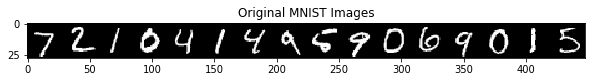

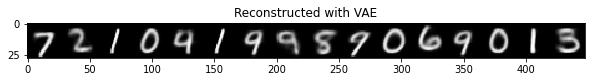

mu tf.Tensor(
[[ 3.3852758   0.7330978 ]
 [-0.03792495  1.7101142 ]
 [-1.1645019  -2.5497801 ]
 [-2.4728398   1.1932756 ]
 [ 1.0839514   3.2872038 ]
 [-1.303827   -2.539771  ]
 [ 1.4811513   0.36366782]
 [ 0.3124836   2.5215912 ]
 [ 0.49583817 -0.39729208]
 [ 2.3917508  -0.36981463]
 [-3.2675292   2.1208138 ]
 [-1.0561929   1.9360213 ]
 [ 1.6376836   0.46725968]
 [-2.48349     1.7322006 ]
 [-0.13758151 -1.9450277 ]
 [ 0.0747564   1.0613874 ]], shape=(16, 2), dtype=float32)
vars tf.Tensor(
[[4.6664800e-06 1.3847629e-06]
 [1.0137289e-04 2.7149159e-04]
 [3.5260287e-05 1.3881312e-05]
 [2.2076302e-04 2.0979065e-04]
 [3.7670361e-07 1.0982640e-06]
 [3.3111166e-06 8.1280490e-07]
 [4.1616484e-05 4.5005403e-05]
 [5.8758880e-05 1.4682389e-04]
 [9.0755802e-04 7.0248055e-04]
 [1.4226336e-05 3.6190127e-06]
 [1.4807566e-04 2.3945596e-04]
 [3.3573245e-04 7.2969345e-04]
 [1.7902901e-05 1.2978439e-05]
 [9.2432929e-05 1.5093702e-04]
 [1.2017084e-06 5.5674457e-07]
 [1.3967941e-04 4.7309077e-04]], shape=(1

In [ ]:
# take one batch of our test dataset
for data in test_ds.take(1):
    imgs, label = data
plt.imshow(tf.squeeze(np.concatenate(imgs[0:16], axis=1)))
plt.title('Original MNIST Images')
plt.show()

encoding_mu, encoding_logvar, z = encoder(imgs)
reconstruction = vae(imgs)

plt.imshow(tf.squeeze(np.concatenate(reconstruction[0:16], axis=1)))
plt.title('Reconstructed with VAE')
plt.show()

print("mu", encoding_mu[:16,:])
print("vars", tf.exp(encoding_logvar*0.5)[:16,:])

Some work well, but others not so much.
Note that even "wrong" reconstructions resemble numbers even if it's the wrong
number.
A Convolutional VAE with more layers and longer training would have massively increased the quality of these reconstructions

Let's check the first 5 predicted distributions

Next, we show how the encoder (the recognition network) encodes the test inputs.
For visualization purposes only the mean of the latent space is displayed (and not the variance)

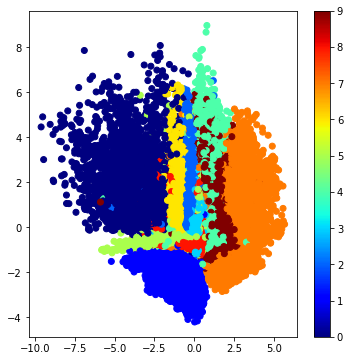

In [ ]:
mu_latent,_,_ = encoder(x_train)
plt.figure(figsize=(6, 6))
plt.scatter(mu_latent[:, 0], mu_latent[:, 1], c=y_train, cmap='jet')
plt.colorbar()
plt.show()

It is visible, that different writings of identical numbers are close together
in the latent space.
Because of the Kullback Leibler loss, the displayed means $\mu$  vary slightly around 0.

### Display 2D manifold of the MNIST digits

Finally we display latent space as a 2D manifold. For this, we sample values from a unit normal distribution, feed them to our decoder and plot reconstrunctions at the positions in the latent space for which they have been generated.

Note: VAEs do not always use a 2D latent space, we just use it for easier visualization
 

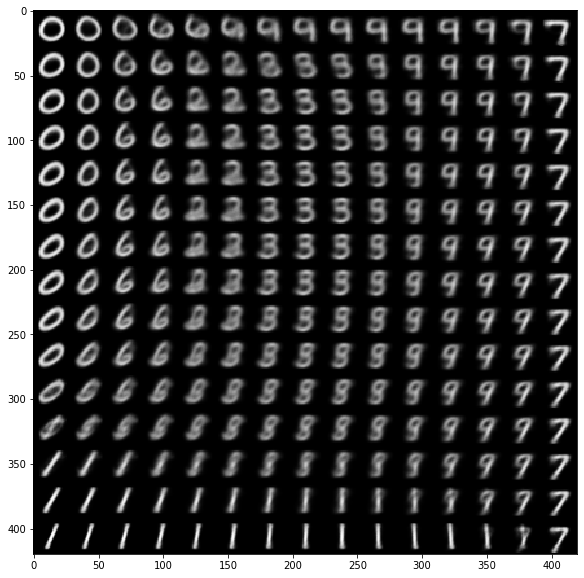

In [ ]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

for i, yi in enumerate(grid_y[::-1]):
    for j, xi in enumerate(grid_x):
        coordinate_tensor = tf.constant([[xi,yi]])
        x_decoded = decoder(coordinate_tensor)
        x_decoded_reshaped = tf.reshape(x_decoded,(1,digit_size, digit_size))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = x_decoded_reshaped


plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

The decoded latent space shows gradual changes between numbers

# 3. Generative Adversarial Networks (GANs)

A GAN is built up of two different neural networks:
* a **discriminator** classifies images as being real (belonging to the training set) or fake (not present in the training set)
* a **generator** takes random noise (or images, compare CycleGAN) as input and transforms it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produces are real.

This is an iterative process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. 

We will use the **non-saturating heuristic** from the lecture: instead of maximizing the probability that the discriminator makes the correct choice, we will instead maximize the probability of the **discriminator making the incorrect choice**. 

We will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### Setup

In [ ]:
# number of images for each batch
batch_size = 128
# the noise dimension. The generator takes 96 values as input and generates from
# them an image
noise_dim = 96

plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def deprocess_img(x):
    """convert values from (-1,1) to (0,1)"""
    return (x + 1.0) / 2.0

def show_images(images):
    """visualize generated images"""
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    images = deprocess_img(images)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

### MNIST Dataset

Earlier for our VAE our images were normalized to [0,1].
For GAN we normalize the images to [-1,1].

In [ ]:
train_images = x_train * 2 - 1 # Normalize the images to [-1, 1]
print(train_images.shape)
buffer_size = 60000
# Batch and shuffle the data
train_dataset = Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size, drop_remainder=True)

(60000, 28, 28, 1)


### Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [ ]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    random_noise = tf.random.uniform(shape=(batch_size, dim), minval=-1, maxval=1, dtype=tf.float32)
    return random_noise

### Discriminator

Architecture:
 * Flatten the width, height and channels from 28x28x1 to 784
 * FC layer with 256 neurons
 * LeakyReLU with alpha 0.01
 * FC layer with 256 neurons
 * LeakyReLU with alpha 0.01
 * FC layer with 1 neuron
 
The output of the discriminator has shape `[batch_size, 1]`.
It predicts, if an input image is real or generated.

In [ ]:
def create_discriminator():
    """
    Create and return a discriminator
    """
    discriminator = tf.keras.Sequential(
        [
            Flatten(),
            Dense(units=256),
            LeakyReLU(alpha=0.01),
            Dense(units=256),
            LeakyReLU(alpha=0.01),
            Dense(units=1)
        ]
    )
    return discriminator

### Generator

Architecture:
 * FC with 1024 neurons
 * ReLU
 * FC layer with 1024 neurons 
 * ReLU
 * FC layer with 784 neurons
 * TanH (To restrict the output to be [-1,1])
 * Reshape 784 into a 28x28x1 image

 
The generator takes a random noise value and predicts a 28*28 pixel image

In [ ]:
def create_generator():
    """
    Create and return a generator
    """
    generator = tf.keras.Sequential(
        [
            Dense(units=1024, activation='relu'), # we could use leaky ReLU here
            Dense(units=1024, activation='relu'), # but it doesn't really matter
            Dense(units=28*28, activation='tanh'),
            Reshape((28,28,1)) # channel = 1 because of grey scale and not RGB
        ]
    )
    return generator

Initialize our generator and discriminator.

Show initial generated images and their corresponding predictions

Initial generated images


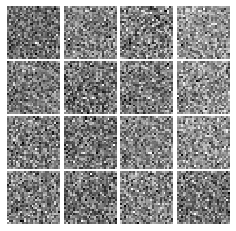

Discriminator Certainty of first row 
 ['0.53', '0.48', '0.52', '0.51', '0.49']

The Generator produces random images, and the Discriminator guesseswith ~0.5 certainty that they are real or fake
Let's train them to change that 


In [ ]:
# create random noise for generator input
noise = sample_noise(batch_size, noise_dim)

# create generator with random weights
generator = create_generator()
# generate images with this random noise
generated_image = generator(noise, training=False)

print("Initial generated images")
fig = show_images(generated_image[:16])
plt.show()

# create discriminator with random weights
discriminator = create_discriminator()

# discriminate the generated images
decision = discriminator(generated_image)
dc_certainty = [str(*x) for x in tf.nn.sigmoid(decision[:5]).numpy().round(decimals=2)]
print('Discriminator Certainty of first row \n',
      dc_certainty)
print("")
print("The Generator produces random images, and the Discriminator guesses"+ \
      "with ~0.5 certainty that they are real or fake")
print("Let's train them to change that ")

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

In [ ]:
def disc_loss(logits_real, logits_fake):
    """Calculate the discriminator loss
    Inputs:
        - logits_real: the output of the discriminator for real images
        - logits_fake: the output of the discriminator for generated images.
    Returns:
        - The loss scalar of the discriminator"""
        

    # labels are '1' for every real image and '0' for every generated image 
    true_labels = tf.ones_like(logits_real)
    
    # DISCRIMINATOR loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images
    real_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=true_labels)
    fake_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=1-true_labels)
    
    # Combine and average losses over the batch
    discriminator_loss = tf.reduce_mean(real_image_loss + fake_image_loss)
    
    return discriminator_loss


def gen_loss(logits_fake):
    """Calculate the generator loss
    Input:
        - logits_fake: the output of the discriminator for generated images
    Returns:
        - The loss scalar of the generator"""
    
    # True labels (1) for fake images
    true_labels = tf.ones_like(logits_fake)

    # The generator tries to increase the certainty of the discriminator for all its fake images
    generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=true_labels)
    
    # Average generator loss over the batch
    generator_loss = tf.reduce_mean(generator_loss)
    
    return generator_loss

### Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [ ]:
def get_optimizers(learning_rate=1e-3, beta1=0.5):
    """Create optimizers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - disc_optimizer: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - gen_optimizer: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)
    
    return disc_optimizer, gen_optimizer

# Get our adam optimizers
disc_optimizer, gen_optimizer = get_optimizers()

### Creating a training step which is used in out training loop


In [ ]:

"""
Tensorflow 2.x uses eager execution by default.
@tf.function creates graphs and can increase performance drastically
The speedup here with @tf.function per epoch is between 100 and 400%
"""

@tf.function
def train_step(inputs, generator, discriminator):
    """Update the weights once of a given discriminator and a given generator
    Inputs:
        - inputs: the MNIST images for the discriminator
        - generator: a created generator
        - discriminator: a created discriminator
    """
    
    # Create new noise for every training step
    noise = sample_noise(batch_size, noise_dim)
    # we need gradients for our generator and disriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate images with our random noise
        generated_imgs = generator(noise, training=True)
        # Discriminator predicts if MNIST images are real
        logits_real = discriminator(inputs, training=True)
        # Discriminator predicts if generated images are real
        logits_fake = discriminator(generated_imgs, training=True)
        
        # get our losses for discriminator and generator
        g_loss = gen_loss(logits_fake)
        d_loss = disc_loss(logits_real, logits_fake)

    # calculate the gradients of the generator and the discriminator with regards to the loss
    gradients_gen = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    # Use our Adam optimizers to update weights with the corresponding gradients
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

#### Train your GAN! This should take about 10 minutes on a CPU, or less than minute on GPU.

For the visualization we always take the same noise to see improvements
Make sure the discriminator loss isn't '0' because this is a signal for an instable training


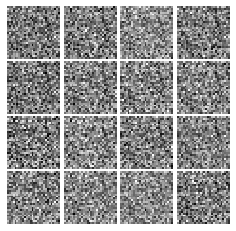


Iter: 0, Disc Loss: 1.6, Gen Loss:0.22
Iter: 100, Disc Loss: 1.5, Gen Loss:0.28
Iter: 200, Disc Loss: 0.96, Gen Loss:0.68


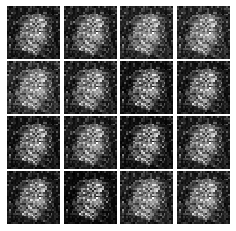


Iter: 300, Disc Loss: 2.5, Gen Loss:0.094
Iter: 400, Disc Loss: 0.95, Gen Loss:1.1
Epoch 1 finished in 3.4 seconds


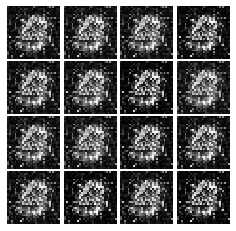


Iter: 0, Disc Loss: 1.2, Gen Loss:0.42
Iter: 100, Disc Loss: 0.91, Gen Loss:2.2
Iter: 200, Disc Loss: 0.98, Gen Loss:1.6


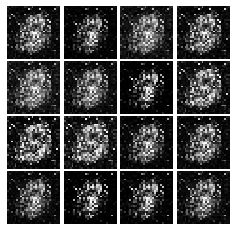


Iter: 300, Disc Loss: 0.61, Gen Loss:1.2
Iter: 400, Disc Loss: 0.74, Gen Loss:1.3
Epoch 2 finished in 2.5 seconds


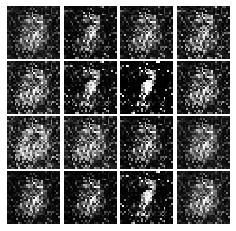


Iter: 0, Disc Loss: 0.77, Gen Loss:0.93
Iter: 100, Disc Loss: 0.71, Gen Loss:1.2
Iter: 200, Disc Loss: 0.81, Gen Loss:1.4


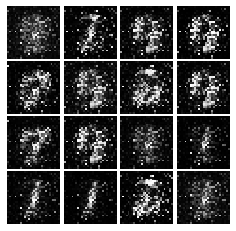


Iter: 300, Disc Loss: 1.1, Gen Loss:0.55
Iter: 400, Disc Loss: 1.3, Gen Loss:2.9
Epoch 3 finished in 2.7 seconds


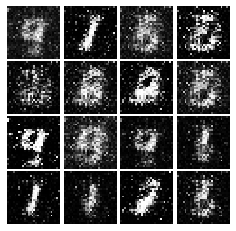


Iter: 0, Disc Loss: 0.81, Gen Loss:1.5
Iter: 100, Disc Loss: 1.2, Gen Loss:0.91
Iter: 200, Disc Loss: 0.68, Gen Loss:1.3


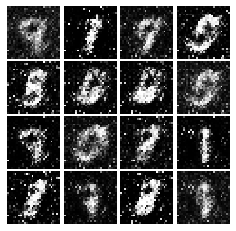


Iter: 300, Disc Loss: 0.86, Gen Loss:1.1
Iter: 400, Disc Loss: 1.3, Gen Loss:1.0
Epoch 4 finished in 2.6 seconds


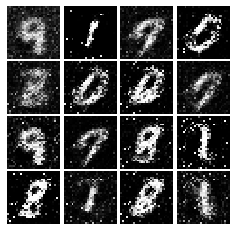


Iter: 0, Disc Loss: 1.0, Gen Loss:0.88
Iter: 100, Disc Loss: 1.1, Gen Loss:0.9
Iter: 200, Disc Loss: 0.98, Gen Loss:1.3


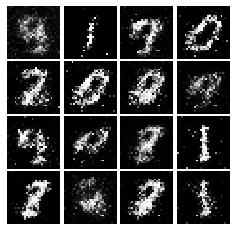


Iter: 300, Disc Loss: 1.0, Gen Loss:0.81
Iter: 400, Disc Loss: 1.1, Gen Loss:0.98
Epoch 5 finished in 2.5 seconds


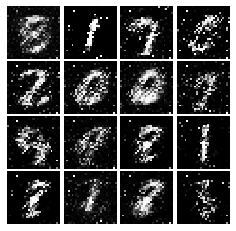


Iter: 0, Disc Loss: 1.0, Gen Loss:0.72
Iter: 100, Disc Loss: 1.1, Gen Loss:0.84
Iter: 200, Disc Loss: 1.2, Gen Loss:0.94


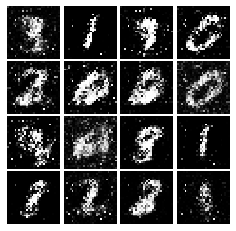


Iter: 300, Disc Loss: 0.97, Gen Loss:0.99
Iter: 400, Disc Loss: 1.2, Gen Loss:0.95
Epoch 6 finished in 2.7 seconds


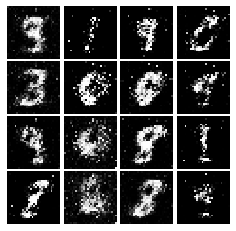


Iter: 0, Disc Loss: 1.3, Gen Loss:0.46
Iter: 100, Disc Loss: 1.4, Gen Loss:0.7
Iter: 200, Disc Loss: 1.3, Gen Loss:1.4


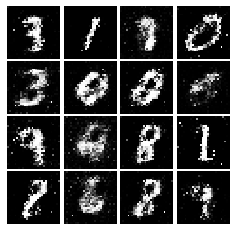


Iter: 300, Disc Loss: 1.4, Gen Loss:0.72
Iter: 400, Disc Loss: 1.3, Gen Loss:0.91
Epoch 7 finished in 2.6 seconds


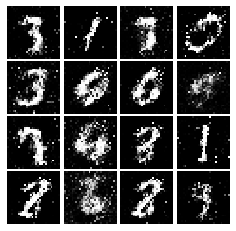


Iter: 0, Disc Loss: 1.1, Gen Loss:0.87
Iter: 100, Disc Loss: 1.2, Gen Loss:0.95
Iter: 200, Disc Loss: 1.1, Gen Loss:0.85


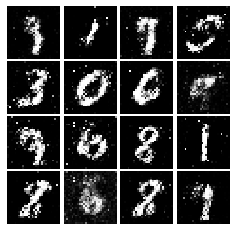


Iter: 300, Disc Loss: 1.1, Gen Loss:0.92
Iter: 400, Disc Loss: 1.1, Gen Loss:1.1
Epoch 8 finished in 2.5 seconds


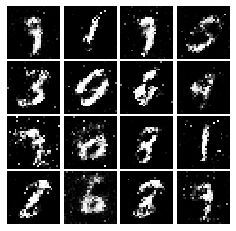


Iter: 0, Disc Loss: 1.2, Gen Loss:0.93
Iter: 100, Disc Loss: 1.2, Gen Loss:0.91
Iter: 200, Disc Loss: 1.2, Gen Loss:0.89


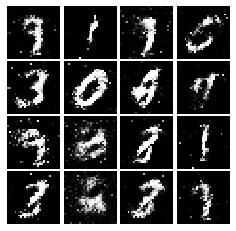


Iter: 300, Disc Loss: 1.3, Gen Loss:0.94
Iter: 400, Disc Loss: 1.2, Gen Loss:1.3
Epoch 9 finished in 2.6 seconds


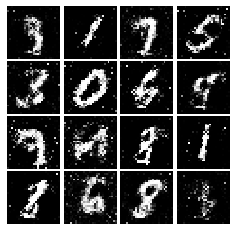


Iter: 0, Disc Loss: 1.2, Gen Loss:0.81
Iter: 100, Disc Loss: 1.1, Gen Loss:1.1
Iter: 200, Disc Loss: 1.4, Gen Loss:1.4


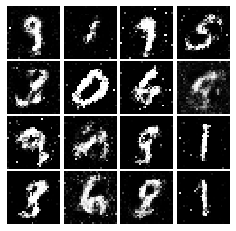


Iter: 300, Disc Loss: 1.2, Gen Loss:0.87
Iter: 400, Disc Loss: 1.0, Gen Loss:1.1
Epoch 10 finished in 2.7 seconds


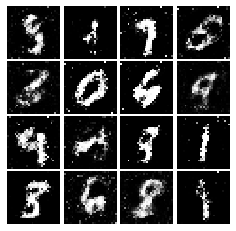


Iter: 0, Disc Loss: 1.2, Gen Loss:0.78
Iter: 100, Disc Loss: 0.95, Gen Loss:1.1
Iter: 200, Disc Loss: 1.1, Gen Loss:0.89


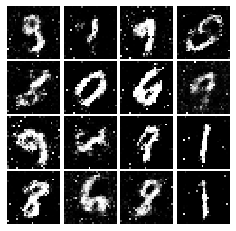


Iter: 300, Disc Loss: 1.2, Gen Loss:0.86
Iter: 400, Disc Loss: 1.2, Gen Loss:0.82
Epoch 11 finished in 2.5 seconds


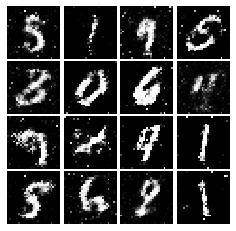


Iter: 0, Disc Loss: 1.3, Gen Loss:0.83
Iter: 100, Disc Loss: 1.1, Gen Loss:1.1
Iter: 200, Disc Loss: 1.2, Gen Loss:0.82


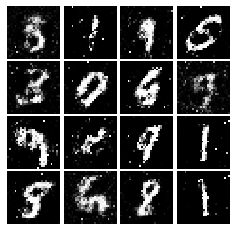


Iter: 300, Disc Loss: 1.2, Gen Loss:0.89
Iter: 400, Disc Loss: 1.1, Gen Loss:1.2
Epoch 12 finished in 2.6 seconds


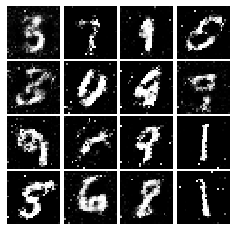


Iter: 0, Disc Loss: 1.1, Gen Loss:0.78
Iter: 100, Disc Loss: 1.3, Gen Loss:0.67
Iter: 200, Disc Loss: 1.2, Gen Loss:0.92


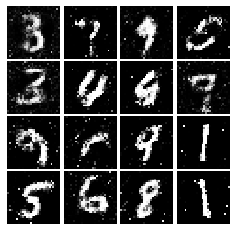


Iter: 300, Disc Loss: 1.1, Gen Loss:1.0
Iter: 400, Disc Loss: 1.2, Gen Loss:1.1
Epoch 13 finished in 2.6 seconds


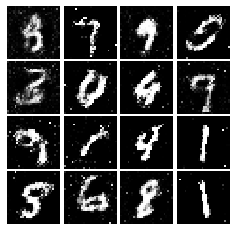


Iter: 0, Disc Loss: 1.2, Gen Loss:0.86
Iter: 100, Disc Loss: 0.98, Gen Loss:1.1
Iter: 200, Disc Loss: 1.3, Gen Loss:0.89


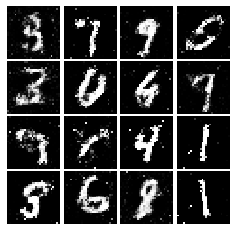


Iter: 300, Disc Loss: 1.3, Gen Loss:0.74
Iter: 400, Disc Loss: 1.1, Gen Loss:0.94
Epoch 14 finished in 2.5 seconds


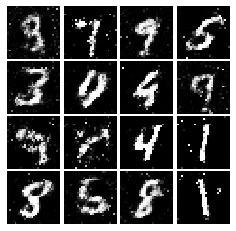


Iter: 0, Disc Loss: 1.1, Gen Loss:1.1
Iter: 100, Disc Loss: 1.3, Gen Loss:0.82
Iter: 200, Disc Loss: 1.2, Gen Loss:0.77


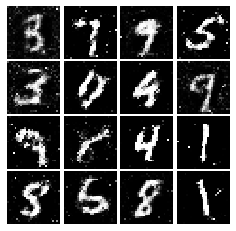


Iter: 300, Disc Loss: 1.2, Gen Loss:0.86
Iter: 400, Disc Loss: 1.2, Gen Loss:0.94
Epoch 15 finished in 5.2 seconds
Final images


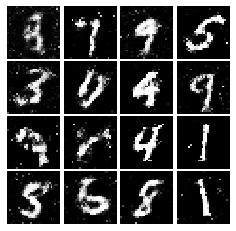

In [ ]:
def run_gan(generator, discriminator,train_step,show_every=250, print_every=100, batch_size=batch_size, num_epoch=15):
    """
    Train a Gan for a certain amount of epochs
    Inputs:
        - generator: A generator for a gan
        - discriminator: A discriminator for a gan
        - train_step: The function that gets executed on every image batch
        - show_every: How many steps between visualization of generated images
        - print_every: The generator and discriminator loss of the current batch
        - batch_size: Batchsize of the dataset
        - num_epoch: How often do we iterate through the dataset"""
    
    # For the visualization we always the same noise to see improvements
    vis_noise = sample_noise(batch_size, noise_dim)
    print("For the visualization we always take the same noise to see improvements")
    print("Make sure the discriminator loss isn't '0' because this is a signal for an instable training")
    for epoch in range(num_epoch):
        epoch_start = time.time()
        for it, image_batch in enumerate(train_dataset):
            # train a batch of images
            train_step(image_batch, generator, discriminator)              
            
            
            # every so often, show 16 generated pictures using the same noise
            if it % show_every == 0:
                samples = generator(vis_noise, training=False)
                fig = show_images(samples[:16])
                plt.show()
                print()
            
            if it % print_every == 0:
                # calculate loss for current batch with eager execution
                generated_imgs = generator(vis_noise, training=False)
                logits_real = discriminator(image_batch, training=False)        
                logits_fake = discriminator(generated_imgs, training=False)
                g_loss = tf.reduce_mean(gen_loss(logits_fake)).numpy()
                d_loss = tf.reduce_mean(disc_loss(logits_real, logits_fake)).numpy()
                print('Iter: {}, Disc Loss: {:.2}, Gen Loss:{:.2}'.format(it,d_loss,g_loss))

        print("Epoch {} finished in {:.2} seconds".format(epoch+1, time.time()-epoch_start))


    print('Final images')
    samples = generator(vis_noise, training=False)
    fig = show_images(samples[:16])
    plt.show()

# Lets train our GAN
run_gan(generator, discriminator, train_step)

### Deep Convolutional GANs (DCGANs)

Vanilla GAN (above) allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* FC size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* FC size 1

In [ ]:
def create_conv_discriminator():
    """
    Build a discriminator with convolutional layers.
    Returns:
    Keras model which predicts in shape [batch_size, 1].
    This prediction contains the evaluation if an image is fake or real
    """
    discriminator = tf.keras.Sequential(
        [
            Reshape((28,28,1)),
            Conv2D(filters=32, kernel_size=5, strides=1),
            LeakyReLU(alpha=0.01),
            MaxPooling2D(pool_size=2, strides=2),
            Conv2D(filters=64, kernel_size=5, strides=1),
            LeakyReLU(alpha=0.01),
            MaxPooling2D(pool_size=2, strides=2),
            Flatten(),
            Dense(units=1024),
            LeakyReLU(alpha=0.01),
            Dense(units=1)
        ]
    )
    return discriminator

#### Generator
Architecture:
* FC of size 1024, ReLU
* BatchNorm
* FC of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [ ]:
def create_conv_generator():
    """
    Create and return a generator that takes noise as input
    and generates images with size 28*28
    """
    generator = tf.keras.Sequential(
        [
            Dense(units=1024,activation='relu'),
            BatchNormalization(),
            Dense(units=7*7*128, activation='relu'),
            BatchNormalization(),
            Reshape((7,7,128)),
            Conv2DTranspose(filters=64, kernel_size=4, strides=2, activation='relu', padding='same'),
            BatchNormalization(),
            # final activation is tanh to force pixel values between (-1,1)
            Conv2DTranspose(filters=1, kernel_size=4, strides=2, activation='tanh', padding='same'),
        ]
    )
    return generator

Initialize the generator/discriminator and show initial images


Initial generated images


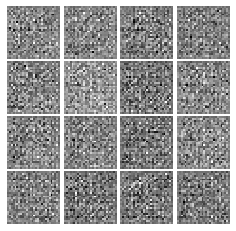

Discriminator Certainty of first row 
 ['0.5', '0.5', '0.5', '0.5', '0.5']

The Generator produces random images, and the Discriminator guesseswith ~0.5 certainty that they are real or fake
Let's train them to change that 


In [ ]:
dc_generator = create_conv_generator()
initial_img = dc_generator(noise)

print("Initial generated images")
fig = show_images(initial_img[:16])
plt.show()

dc_discriminator = create_conv_discriminator()
decision = dc_discriminator(initial_img)
dc_certainty = [str(*x) for x in tf.nn.sigmoid(decision[:5]).numpy().round(decimals=2)]
print('Discriminator Certainty of first row \n',
      dc_certainty)
print("")
print("The Generator produces random images, and the Discriminator guesses"+ \
      "with ~0.5 certainty that they are real or fake")
print("Let's train them to change that ")

### Let's train our newly created Deep Convolutional GAN
Create a train_step function, which is identical to the train
step function of the vanilla GAN.


Then train new generator and discriminator.
Also reduce the amount of epochs for faster results


For the visualization we always take the same noise to see improvements
Make sure the discriminator loss isn't '0' because this is a signal for an instable training


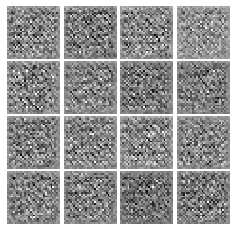


Iter: 0, Disc Loss: 1.3e+01, Gen Loss:2.8e-06
Iter: 100, Disc Loss: 0.44, Gen Loss:2.2
Iter: 200, Disc Loss: 0.79, Gen Loss:1.5


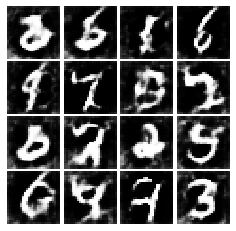


Iter: 300, Disc Loss: 0.81, Gen Loss:1.3
Iter: 400, Disc Loss: 0.87, Gen Loss:1.2
Epoch 1 finished in 8.9 seconds


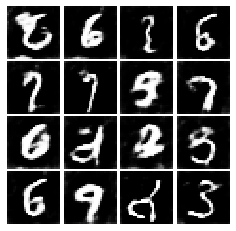


Iter: 0, Disc Loss: 1.2, Gen Loss:2.4
Iter: 100, Disc Loss: 0.94, Gen Loss:1.3
Iter: 200, Disc Loss: 0.96, Gen Loss:1.2


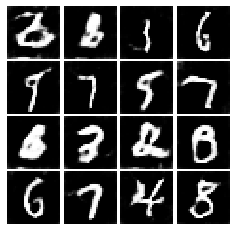


Iter: 300, Disc Loss: 0.91, Gen Loss:1.3
Iter: 400, Disc Loss: 1.1, Gen Loss:0.71
Epoch 2 finished in 7.5 seconds


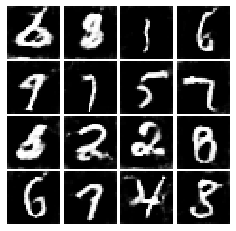


Iter: 0, Disc Loss: 0.97, Gen Loss:1.3
Iter: 100, Disc Loss: 0.89, Gen Loss:1.4
Iter: 200, Disc Loss: 1.0, Gen Loss:1.0


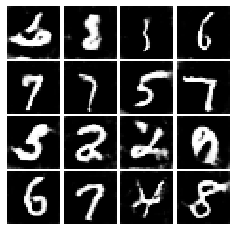


Iter: 300, Disc Loss: 0.95, Gen Loss:1.2
Iter: 400, Disc Loss: 0.96, Gen Loss:1.1
Epoch 3 finished in 7.4 seconds


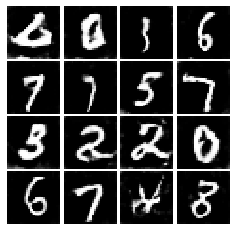


Iter: 0, Disc Loss: 0.96, Gen Loss:1.1
Iter: 100, Disc Loss: 0.99, Gen Loss:1.5
Iter: 200, Disc Loss: 1.0, Gen Loss:1.4


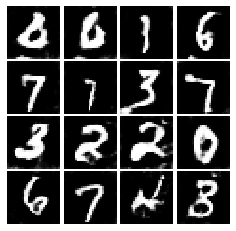


Iter: 300, Disc Loss: 0.91, Gen Loss:1.3
Iter: 400, Disc Loss: 0.95, Gen Loss:1.2
Epoch 4 finished in 7.2 seconds


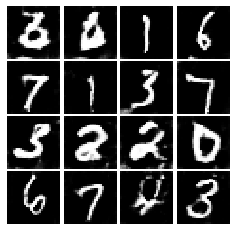


Iter: 0, Disc Loss: 1.1, Gen Loss:1.6
Iter: 100, Disc Loss: 0.96, Gen Loss:0.94
Iter: 200, Disc Loss: 0.99, Gen Loss:1.6


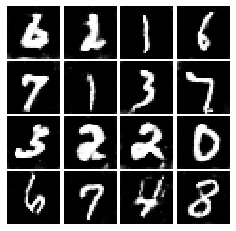


Iter: 300, Disc Loss: 1.0, Gen Loss:0.77
Iter: 400, Disc Loss: 1.1, Gen Loss:1.4
Epoch 5 finished in 7.4 seconds
Final images


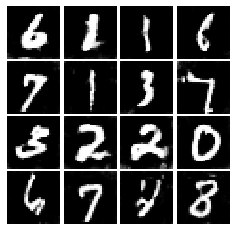

In [ ]:
@tf.function
def train_step_dc(inputs, generator, discriminator):
    
    noise = sample_noise(batch_size, noise_dim)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_imgs = generator(noise, training=True)
        
        logits_real = discriminator(inputs, training=True)
        logits_fake = discriminator(generated_imgs, training=True)
        
        g_loss = gen_loss(logits_fake)
        d_loss = disc_loss(logits_real, logits_fake)

    # calculate the gradients with regards to the loss
    gradients_gen = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    # Use Adam optimizer to update weights with the gradients
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

#decrease epoch size for faster results (our vanilla GAN used 10 epochs)
run_gan(dc_generator, dc_discriminator, train_step_dc, num_epoch=5)